# SVM on MNIST dataset

In [1]:
import numpy as np
import csv

def CSV_image_load(path):
    image_list = []
    with open(path) as csvfile:
        rows = csv.reader(csvfile)
        for row in rows:
            i = 0
            j = 0
            image = np.zeros((28,28))
            for col in row:
                image[i,j] = col
                i += 1
                if i == 28:
                    i = 0
                    j += 1
            image_list.append(image)
    return np.asarray(image_list, dtype='float').reshape(-1, 784)
    
def CSV_label_load(path):
    label_list = []
    with open(path) as csvfile:
        rows = csv.reader(csvfile)
        for row in rows:
            label_list.append(row)
            
        return np.asarray(label_list, dtype='float').reshape(-1,)

x_train = CSV_image_load('X_train.csv') # (n, 784)
x_test = CSV_image_load('X_test.csv') # (n,)
y_train = CSV_label_load('Y_train.csv') # (n, 784)
y_test = CSV_label_load('Y_test.csv') # (n,)

### -t kernel_type : set type of kernel function (default 2)
- 0 -- linear: u'*v
- 1 -- polynomial: (gamma\*u'*v + coef0)^degree
- 2 -- radial basis function: exp(-gamma*|u-v|^2)
- 3 -- sigmoid: tanh(gamma\*u'*v + coef0)

In [2]:
from libsvm.svmutil import *

kernel_types = {'linear':'-t 0', 'polynomial':'-t 1', 'radial basis function':'-t 2'}
accuracy = []
for k,param in kernel_types.items():
    model = svm_train(y_train, x_train, param)
    p_labs, p_acc, p_vals = svm_predict(y_test, x_test, model)
    accuracy.append(p_acc[0])

Accuracy = 95.08% (2377/2500) (classification)
Accuracy = 35.12% (878/2500) (classification)
Accuracy = 95.32% (2383/2500) (classification)


In [3]:
i = 0
for k, v in kernel_types.items():
    print(f'{k} kernel accuracy: {accuracy[i]:.2f}%')
    i += 1

linear kernel accuracy: 95.08%
polynomial kernel accuracy: 35.12%
radial basis function kernel accuracy: 95.32%


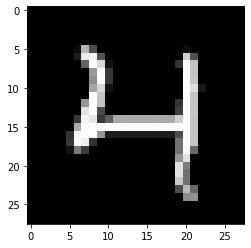

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(x_train[4560].reshape(28,28), cmap='gray')

### -s svm_type : set type of SVM (default 0)
- 0 -- C-SVC
- 1 -- nu-SVC
- 2 -- one-class SVM
- 3 -- epsilon-SVR
- 4 -- nu-SVR
<br>

* -c cost : set the parameter C of C-SVC, epsilon-SVR, and nu-SVR (default 1)
* -g gamma : set gamma in kernel function (default 1/k)
* -r coef0 : set coef0 in kernel function (default 0)
* -d degree : set degree in kernel function (default 3)

## Linear kernel Grid Search

In [5]:
def grid_search_linear(log2c, x_train, y_train, x_test, y_test):
    best_log2c = best_acc = 0
    confusion_matrix = np.zeros((len(log2c)))
    
    for i in range(len(log2c)):
        param = f'-q -t 0 -v 5 -c {2**log2c[i]}'
        acc = svm_train(y_train, x_train, param)
        print(f'[{i+1} / {len(log2c)}] Cost: {2**log2c[i]}, Accuracy: {acc:.2f}%\n')
        confusion_matrix[i] = acc
        if acc > best_acc:
            best_acc = acc
            best_log2c = log2c[i]
                
    print(f'Best setting: Cost: {2**best_log2c}, Accuracy: {best_acc:.3f}%')
            
    return confusion_matrix, best_log2c

log2c = [-7, -6, -5, -4, -3, -2, -1, 0, 1, 2]
confusion_matrix, best_log2c = grid_search_linear(log2c, x_train, y_train, x_test, y_test)

Cross Validation Accuracy = 96.98%
[1 / 10] Cost: 0.0078125, Accuracy: 96.98%

Cross Validation Accuracy = 96.98%
[2 / 10] Cost: 0.015625, Accuracy: 96.98%

Cross Validation Accuracy = 97.04%
[3 / 10] Cost: 0.03125, Accuracy: 97.04%

Cross Validation Accuracy = 97%
[4 / 10] Cost: 0.0625, Accuracy: 97.00%

Cross Validation Accuracy = 96.96%
[5 / 10] Cost: 0.125, Accuracy: 96.96%

Cross Validation Accuracy = 96.72%
[6 / 10] Cost: 0.25, Accuracy: 96.72%

Cross Validation Accuracy = 96.42%
[7 / 10] Cost: 0.5, Accuracy: 96.42%

Cross Validation Accuracy = 96.52%
[8 / 10] Cost: 1, Accuracy: 96.52%

Cross Validation Accuracy = 96.18%
[9 / 10] Cost: 2, Accuracy: 96.18%

Cross Validation Accuracy = 96.38%
[10 / 10] Cost: 4, Accuracy: 96.38%

Best setting: Cost: 0.03125, Accuracy: 97.040%


## Linear kernel Prediction on Testing Set

In [6]:
param = f'-q -t 0 -c {2**best_log2c}'
model = svm_train(y_train, x_train, param)

p_label, p_acc, p_vals = svm_predict(y_test, x_test, model)
print(f'Optimal Parameters Linear kernel, Cost: {2**best_log2c}, Accuracy: {p_acc[0]:.2f}%')

Accuracy = 96% (2400/2500) (classification)
Optimal Parameters Linear kernel, Cost: 0.03125, Accuracy: 96.00%


## Polynomial kernel Grid Search

In [7]:
def grid_search_poly(log2c, log2g, log2r, x_train, y_train, x_test, y_test):
    best_log2c = best_log2g = best_log2r = best_acc = 0
    confusion_matrix = np.zeros((len(log2c), len(log2g), len(log2r)))
    
    for i in range(len(log2c)):
        for j in range(len(log2g)):
            for k in range(len(log2r)):
                param = f'-q -t 1 -v 5 -c {2**log2c[i]} -g {2**log2g[j]} -r {2**log2r[k]} -d 2'
                acc = svm_train(y_train, x_train, param)
                print(f'[{k+j*len(log2g)+i*len(log2c)*len(log2g)+1} / {len(log2c)*len(log2g)*len(log2r)}] Cost: {2**log2c[i]}, Gamma: {2**log2g[j]}, coef0 : {2**log2r[k]}, Accuracy: {acc:.2f}%\n')
                confusion_matrix[i,j] = acc
                if acc > best_acc:
                    best_acc = acc
                    best_log2c = log2c[i]
                    best_log2g = log2g[j]
                    best_log2r = log2r[k]
                
    print(f'Best setting: Cost: {2**best_log2c}, Gamma: {2**best_log2g}, coef0 : {2**log2r[k]}, Accuracy: {best_acc:.3f}%')
            
    return confusion_matrix, best_log2c, best_log2g, best_log2r

log2c = [-4, -3, -2]
log2g = [12, 13, 14]
log2r = [4, 5, 6]
confusion_matrix, best_log2c, best_log2g, best_log2r = grid_search_poly(log2c, log2g, log2r, x_train, y_train, x_test, y_test)

Cross Validation Accuracy = 98.14%
[1 / 27] Cost: 0.0625, Gamma: 4096, coef0 : 16, Accuracy: 98.14%

Cross Validation Accuracy = 98.16%
[2 / 27] Cost: 0.0625, Gamma: 4096, coef0 : 32, Accuracy: 98.16%

Cross Validation Accuracy = 98.14%
[3 / 27] Cost: 0.0625, Gamma: 4096, coef0 : 64, Accuracy: 98.14%

Cross Validation Accuracy = 98.18%
[4 / 27] Cost: 0.0625, Gamma: 8192, coef0 : 16, Accuracy: 98.18%

Cross Validation Accuracy = 98.12%
[5 / 27] Cost: 0.0625, Gamma: 8192, coef0 : 32, Accuracy: 98.12%

Cross Validation Accuracy = 97.96%
[6 / 27] Cost: 0.0625, Gamma: 8192, coef0 : 64, Accuracy: 97.96%

Cross Validation Accuracy = 98.08%
[7 / 27] Cost: 0.0625, Gamma: 16384, coef0 : 16, Accuracy: 98.08%

Cross Validation Accuracy = 98%
[8 / 27] Cost: 0.0625, Gamma: 16384, coef0 : 32, Accuracy: 98.00%

Cross Validation Accuracy = 97.92%
[9 / 27] Cost: 0.0625, Gamma: 16384, coef0 : 64, Accuracy: 97.92%

Cross Validation Accuracy = 98%
[10 / 27] Cost: 0.125, Gamma: 4096, coef0 : 16, Accuracy: 9

## Polynomial kernel Prediction on Testing Set

In [8]:
param = f'-q -t 1 -c {2**best_log2c} -g {2**best_log2g} -r {2**best_log2r} -d 2'
model = svm_train(y_train, x_train, param)

p_label, p_acc, p_vals = svm_predict(y_test, x_test, model)
print(f'Optimal Parameters Polynomial kernel, Cost: {2**best_log2c}, Gamma: {2**best_log2g}, coef0 : {2**best_log2r}, degree : {2}, Accuracy: {p_acc[0]:.2f}%')

Accuracy = 97.68% (2442/2500) (classification)
Optimal Parameters Polynomial kernel, Cost: 0.125, Gamma: 4096, coef0 : 32, degree : 2, Accuracy: 97.68%


## RBF kernel Grid Search

In [9]:
def grid_search(log2c, log2g, x_train, y_train, x_test, y_test):
    best_log2c = best_log2g = best_acc = 0
    confusion_matrix = np.zeros((len(log2c), len(log2g)))
    
    for i in range(len(log2c)):
        for j in range(len(log2g)):
            param = f'-q -t 2 -v 5 -c {2**log2c[i]} -g {2**log2g[j]}'
            acc = svm_train(y_train, x_train, param)
            print(f'[{j+i*len(log2g)+1} / {len(log2c)*len(log2g)}] Cost: {2**log2c[i]}, Gamma: {2**log2g[j]}, Accuracy: {acc:.2f}%\n')
            confusion_matrix[i,j] = acc
            if acc > best_acc:
                best_acc = acc
                best_log2c = log2c[i]
                best_log2g = log2g[j]
                
    print(f'Best setting: Cost: {2**best_log2c}, Gamma: {2**best_log2g}, Accuracy: {best_acc:.3f}%')
            
    return confusion_matrix, best_log2c, best_log2g

log2c = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
log2g = [-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0]
confusion_matrix, best_log2c, best_log2g = grid_search(log2c, log2g, x_train, y_train, x_test, y_test)

Cross Validation Accuracy = 96.14%
[1 / 121] Cost: 1, Gamma: 0.0009765625, Accuracy: 96.14%

Cross Validation Accuracy = 96.72%
[2 / 121] Cost: 1, Gamma: 0.001953125, Accuracy: 96.72%

Cross Validation Accuracy = 97.3%
[3 / 121] Cost: 1, Gamma: 0.00390625, Accuracy: 97.30%

Cross Validation Accuracy = 97.68%
[4 / 121] Cost: 1, Gamma: 0.0078125, Accuracy: 97.68%

Cross Validation Accuracy = 98.22%
[5 / 121] Cost: 1, Gamma: 0.015625, Accuracy: 98.22%

Cross Validation Accuracy = 98.36%
[6 / 121] Cost: 1, Gamma: 0.03125, Accuracy: 98.36%

Cross Validation Accuracy = 97.98%
[7 / 121] Cost: 1, Gamma: 0.0625, Accuracy: 97.98%

Cross Validation Accuracy = 84.72%
[8 / 121] Cost: 1, Gamma: 0.125, Accuracy: 84.72%

Cross Validation Accuracy = 63.46%
[9 / 121] Cost: 1, Gamma: 0.25, Accuracy: 63.46%

Cross Validation Accuracy = 44.6%
[10 / 121] Cost: 1, Gamma: 0.5, Accuracy: 44.60%

Cross Validation Accuracy = 29.88%
[11 / 121] Cost: 1, Gamma: 1, Accuracy: 29.88%

Cross Validation Accuracy = 96.62

Cross Validation Accuracy = 98.5%
[93 / 121] Cost: 256, Gamma: 0.015625, Accuracy: 98.50%

Cross Validation Accuracy = 98.58%
[94 / 121] Cost: 256, Gamma: 0.03125, Accuracy: 98.58%

Cross Validation Accuracy = 98.02%
[95 / 121] Cost: 256, Gamma: 0.0625, Accuracy: 98.02%

Cross Validation Accuracy = 85.84%
[96 / 121] Cost: 256, Gamma: 0.125, Accuracy: 85.84%

Cross Validation Accuracy = 65.96%
[97 / 121] Cost: 256, Gamma: 0.25, Accuracy: 65.96%

Cross Validation Accuracy = 45.68%
[98 / 121] Cost: 256, Gamma: 0.5, Accuracy: 45.68%

Cross Validation Accuracy = 31.5%
[99 / 121] Cost: 256, Gamma: 1, Accuracy: 31.50%

Cross Validation Accuracy = 97.06%
[100 / 121] Cost: 512, Gamma: 0.0009765625, Accuracy: 97.06%

Cross Validation Accuracy = 97.56%
[101 / 121] Cost: 512, Gamma: 0.001953125, Accuracy: 97.56%

Cross Validation Accuracy = 97.64%
[102 / 121] Cost: 512, Gamma: 0.00390625, Accuracy: 97.64%

Cross Validation Accuracy = 98.08%
[103 / 121] Cost: 512, Gamma: 0.0078125, Accuracy: 98.08%

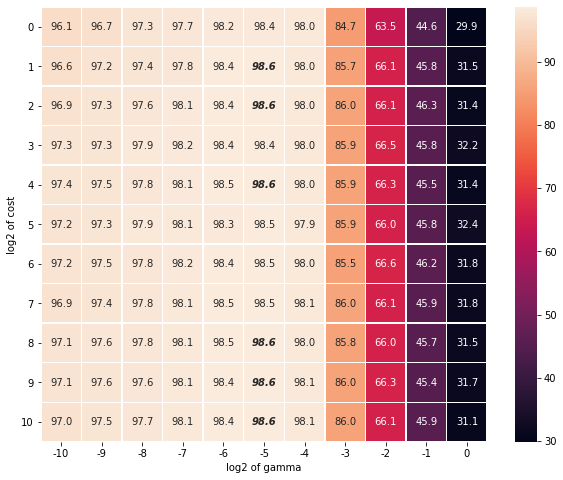

In [10]:
import seaborn as sns
fig, ax = plt.subplots(figsize = (10, 8))
pic = sns.heatmap(confusion_matrix, annot=True, fmt='.1f', linewidths=.5)

ax.set_xticklabels(log2g)
ax.set_xlabel("log2 of gamma")
ax.set_yticklabels(log2c, rotation=360)
ax.set_ylabel("log2 of cost")

for text in pic.texts:
    if float(text.get_text()) > 98.5:
        text.set_weight('bold')
        text.set_style('italic')

## RBF kernel Prediction on Testing Set

In [11]:
param = f'-q -t 2 -c {2**best_log2c} -g {2**best_log2g}'
model = svm_train(y_train, x_train, param)

p_label, p_acc, p_vals = svm_predict(y_test, x_test, model)
print('Optimal Parameters RBF kernel accuracy: {:.2f}%'.format(p_acc[0]))

Accuracy = 98.52% (2463/2500) (classification)
Optimal Parameters RBF kernel accuracy: 98.52%


## Linear + RBF kernel
### Linear kernel: $K(\mathbf{x}, \mathbf{x'})=\mathbf{x}^{T} \mathbf{x'}, \quad \mathbf{x}, \mathbf{x'} \in \mathbb{R}^{d}$
### Radial basis function kernel: $K\left(\mathbf{x}, \mathbf{x}^{\prime}\right)=\exp \left(-\frac{\left\|\mathbf{x}-\mathbf{x}^{\prime}\right\|^{2}}{2 \sigma^{2}}\right)$
$K\left(\mathbf{x}, \mathbf{x}^{\prime}\right)=\exp \left(-\gamma\left\|\mathbf{x}-\mathbf{x}^{\prime}\right\|^{2}\right)$


[What is the fastest way to compute an RBF kernel in python?
](https://stackoverflow.com/questions/47271662/what-is-the-fastest-way-to-compute-an-rbf-kernel-in-python)

New training instance for xi:

<label> 0:i 1:K(xi,x1) ... L:K(xi,xL)

New testing instance for any x:

<label> 0:? 1:K(x,x1) ... L:K(x,xL)

That is, in the training file the first column must be the "ID" of
xi. In testing, ? can be any value.

In [12]:
def linear_RBF_kernel(x, x_prime, gamma):
    linear_kernel = x @ x_prime.T
    x_norm = np.sum(x**2, axis = -1)
    x_prime_norm = np.sum(x_prime**2, axis = -1)
    
    RBF = 1 * np.exp(-gamma * (x_norm[:,None] + x_prime_norm[None,:] - 2 * linear_kernel))
    kernel = RBF + linear_kernel
    kernel = np.hstack((np.arange(1, len(x)+1).reshape(-1,1), kernel)) # Add ID
    return kernel

In [13]:
best_log2c = 7
best_log2g = -5

kernel_train = linear_RBF_kernel(x_train, x_train, 2**best_log2c) # (5000,5001)
kernel_test = linear_RBF_kernel(x_test, x_train, 2**best_log2c) # (2500, 5001)

prob = svm_problem(y_train, kernel_train, isKernel=True)
param = svm_parameter(f'-q -t 4 -c {2**best_log2g}')
model = svm_train(prob, param)


p_label, p_acc, p_vals = svm_predict(y_test, kernel_test, model, '-q')
print('linear kernel + RBF kernel accuracy: {:.2f}%'.format(p_acc[0]))

linear kernel + RBF kernel accuracy: 95.96%
